# AIR QUALITY PREDICTION IN LAGOS

## EXPLORATORY DATA ANALYSIS
- Load Libraries
- Load Dataset
- Overview of the dataset
- Clean Datasets
- Create a Wrangle Function
- Exploration on data

## Load Libraries

In [101]:
# Load Libraries

import pytz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose


## Load Dataset

In [8]:
# file directory
file= "../data/Air_Quality_Data_Lagos.csv"

# load into DataFrame
df = pd.read_csv(file, index_col= "date")
df.head()

,pm25
date,
2023/4/1,64
2023/4/2,53
2023/4/3,60
2023/4/4,98
2023/1/2,345


## Overview of the Dataset


In [12]:
# Size of the Dataset
shape = df.shape

print(f"The Shape of the Dataset is: {shape}")
print(f"The Dataset has: {shape[0]} historical data")
print(f"The dataset have {shape[1]} column. For PM2.5 Readings")

The Shape of the Dataset is: (665, 1)
The Dataset has: 665 historical data
The dataset have 1 column. For PM2.5 Readings


In [20]:
# Range of Data Records
start_date = df.index[-1]
end_date = df.index[0]

print(f"The dataset records is between {start_date} and {end_date}")

The dataset records is between 2021/3/31 and 2023/4/1


In [23]:
# Dataset info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 665 entries, 2023/4/1 to 2021/3/31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   pm25    665 non-null    int64
dtypes: int64(1)
memory usage: 10.4+ KB
None


### Summary

- This Dataset covers for 3 years records.
- Starting from `April 2021` to `April 2023`
- Contains `665` observations
- There are no missing values in the dataset

## Exploratory Data Analysis

- clean dataset
- PM2.5 readings over time
- Rolling Statistics
- Histogram And Boxplots
- Seasonal Decomposition
- ACF and PACF plots

In [42]:
# Clean Dataset
df.index = pd.DatetimeIndex(df.index)

# Localize to Timezone
df.index = df.index.tz_localize("Africa/Lagos")

# rename the "pm25" Column to "PM2.5" for clarity
df = df.rename(columns={"pm25": "PM2.5"})

# Ensure that there are data for every day within the date range
df = df.asfreq("D")

# missing data present in the dataset
missing = df.isna().sum()
print("Missing values:\n", missing)

df.head()

Missing values:
 PM2.5    156
dtype: int64


,PM2.5
date,
2021-01-04 00:00:00+01:00,98.0
2021-01-05 00:00:00+01:00,98.0
2021-01-06 00:00:00+01:00,80.0
2021-01-07 00:00:00+01:00,92.0
2021-01-08 00:00:00+01:00,65.0


In [63]:
# Filling missing values by Linear Interpolation:
df["PM2.5"] = df["PM2.5"].interpolate(method="linear")

# missing data present in the dataset
missing = df.isna().sum()
print("Missing values:\n", missing)

df.head()

Missing values:
 PM2.5    0
dtype: int64


,PM2.5
date,
2021-01-04 00:00:00+01:00,98.0
2021-01-05 00:00:00+01:00,98.0
2021-01-06 00:00:00+01:00,80.0
2021-01-07 00:00:00+01:00,92.0
2021-01-08 00:00:00+01:00,65.0


### Summary

- After using `df.asfreq("D")` to ensure that every day within the dataset date range has a data, it appears that there were `156 days` without data.
- Two options were considered for filling the missing data: `Fill Forward` and `Linear Interpolation`
- Finally, The Linear Interpolation was implemented. Leaving the dataset with no missing PM2.5 reading.

### PM2.5 Over time

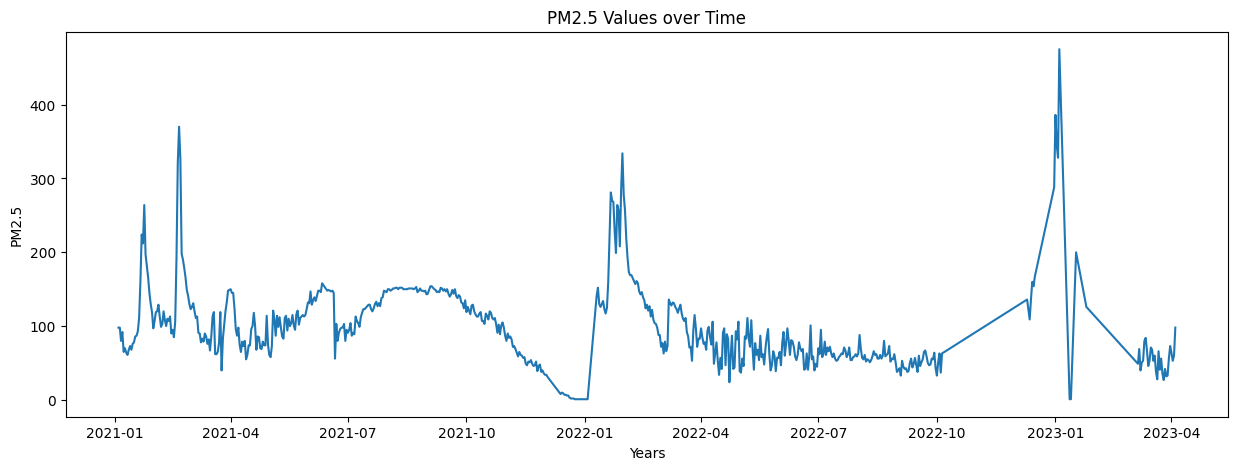

In [65]:
# PM2.5 Over time
fig, ax = plt.subplots(figsize = (15, 5))
plt.plot(df["PM2.5"])
plt.title("PM2.5 Values over Time")
plt.xlabel("Years")
plt.ylabel("PM2.5")
plt.show()

### Rolling Statistics
- Rolling average
- Rolling Standard deviation

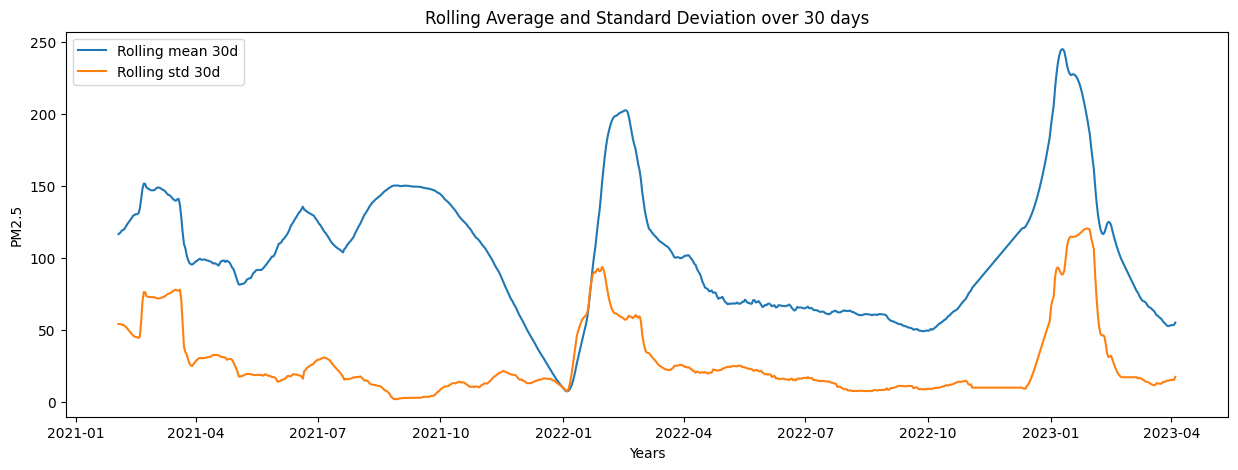

In [89]:
# rolling mean for 30 days
rolling_mean = df["PM2.5"].rolling(window= 30).mean()

# rolling variance for 30 days
rolling_std = df["PM2.5"].rolling(window = 30).std()

# Plot charts
fig, ax = plt.subplots(figsize = (15, 5))
plt.plot(rolling_mean, label = "Rolling mean 30d")
plt.plot(rolling_std, label = "Rolling std 30d")
plt.title("Rolling Average and Standard Deviation over 30 days")
plt.xlabel("Years")
plt.ylabel("PM2.5")

plt.legend()
plt.show()


### Histogram and Boxplot

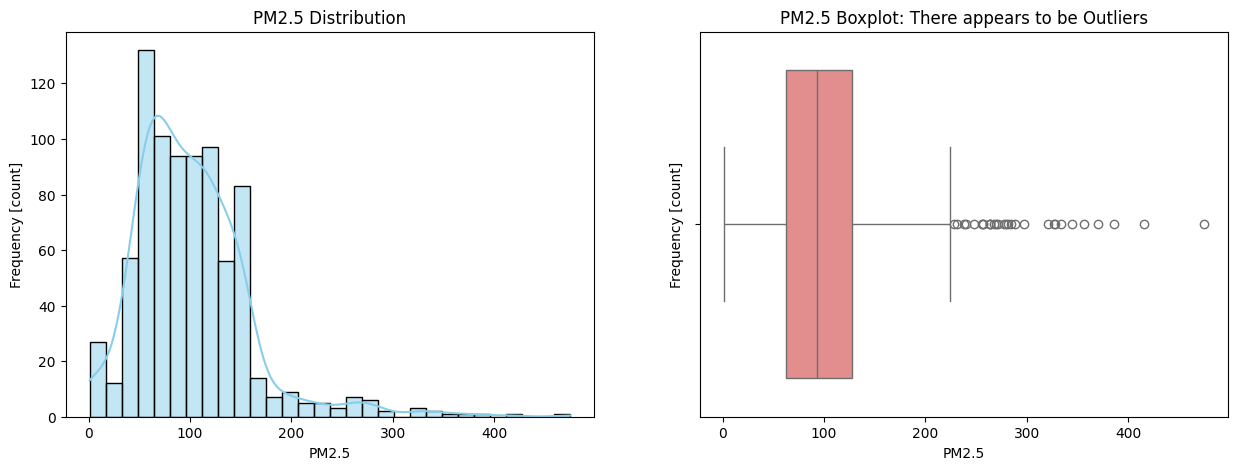

In [100]:
# Figure size
plt.figure(figsize= (15, 5))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(df["PM2.5"], kde=True, bins =  30, color= "skyblue")
plt.title("PM2.5 Distribution")
plt.ylabel("Frequency [count]")

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(df["PM2.5"], color= "lightcoral", orient="h")
plt.title("PM2.5 Boxplot: There appears to be Outliers")
plt.ylabel("Frequency [count]")

plt.show()

### Seasonal Decompose

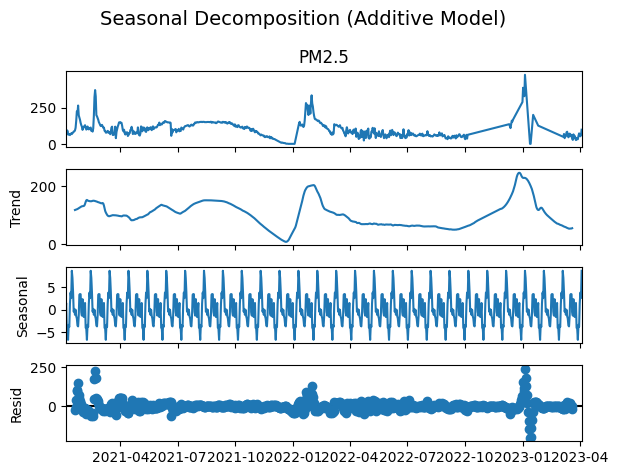

In [103]:
# Instantiate the seasonal_decompose
decomposition = seasonal_decompose(df["PM2.5"], model="additive", period=30)

# Plot the Chart
decomposition.plot()
plt.suptitle("Seasonal Decomposition (Additive Model)", fontsize=14)
plt.tight_layout()
plt.show()

### ACF and PACF Plots


<Figure size 1400x500 with 0 Axes>

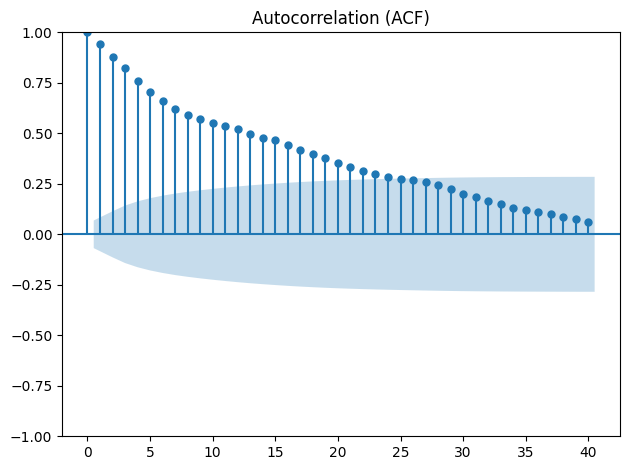

In [111]:
# plot_acf

plt.figure(figsize=(14, 5))
plot_acf(df["PM2.5"].dropna(), lags = 40)
plt.title("Autocorrelation (ACF)")
plt.tight_layout()
plt.show()

<Figure size 1400x500 with 0 Axes>

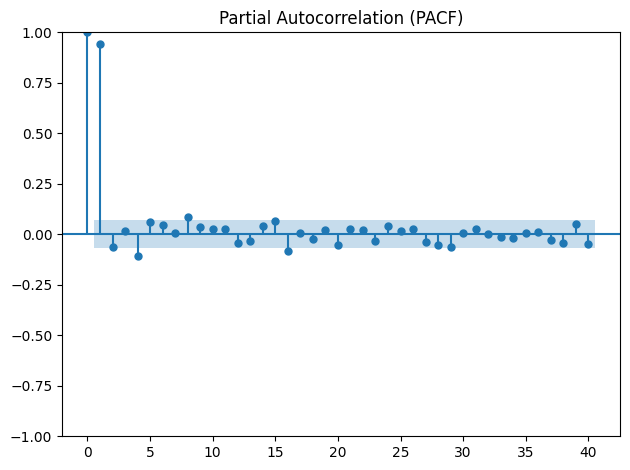

In [113]:
# plot_pacf

plt.figure(figsize=(14, 5))
plot_pacf(df["PM2.5"].dropna(), lags=40)
plt.title("Partial Autocorrelation (PACF)")
plt.tight_layout()
plt.show()

### Summary

- Abnormally Low PM2.5 Readings (e.g., ~0 in Jan 2022 and Jan 2023) which may be due to `Sensor malfunction or downtime`. Solution is to either: Leave them in (let the model learn spikes/drops) or Replace near-zero values with NaN and interpolate.
- **Histogram & Boxplot:** The Distribution is right-skewed, typical for pollution data. And we consider Outliers above 400 µg/m³ very extreme. solution: Cap using winsorization or Cap manually
- **Seasonal Decomposition:** There is clear seasonality — possibly monthly cycles due to climate or traffic. meanwhile, Trend is not constant — major spikes and declines.
- **ACF Plot:** Significant autocorrelation persists up to lag ~30. ARMA/ARIMA appears to be a great choice.
- **PACF Plot:** Shows a strong spike at lag 1, Then mostly dies out. This Suggests AR(1) or ARMA(1,q) could be a strong candidate, and beyond lag 1, there is little additional direct predictive value